# 兰州天气数据分析（使用Plotly可视化）

本notebook使用Plotly库进行交互式可视化分析，包括：
1. 数据预处理
2. 温度分析
3. 天气状况分析
4. 风力分析
5. 综合分析
6. 预测分析

In [16]:
# 导入必要的库
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from scipy import stats

In [18]:
# 读取数据
df = pd.read_excel('../数据集/lanzhou_weather_data.xlsx')

# 数据预处理函数
def extract_temperature(temp_str):
    """提取温度数值"""
    return int(temp_str.replace('℃', ''))

def extract_wind_direction(wind_str):
    """提取风向"""
    if '无持续风向' in wind_str:
        return '无持续风向'
    return wind_str.split()[0]

def extract_wind_force(wind_str):
    """提取风力等级"""
    match = re.search(r'(\d+)-(\d+)级', wind_str)
    if match:
        return (int(match.group(1)) + int(match.group(2))) / 2
    return np.nan

# 处理日期
df['日期'] = pd.to_datetime(df['日期'], format='%Y年%m月%d日')

# 处理温度
df['最高气温_数值'] = df['最高气温'].apply(extract_temperature)
df['最低气温_数值'] = df['最低气温'].apply(extract_temperature)
df['日温差'] = df['最高气温_数值'] - df['最低气温_数值']

# 处理风向和风力
df['白天风向'] = df['白天风力'].apply(extract_wind_direction)
df['夜间风向'] = df['夜间风力'].apply(extract_wind_direction)
df['白天风力等级'] = df['白天风力'].apply(extract_wind_force)
df['夜间风力等级'] = df['夜间风力'].apply(extract_wind_force)

# 添加时间特征
df['年'] = df['日期'].dt.year
df['月'] = df['日期'].dt.month
df['季节'] = pd.cut(df['月'], 
                  bins=[0, 3, 6, 9, 12], 
                  labels=['春季', '夏季', '秋季', '冬季'])

## 2. 温度分析

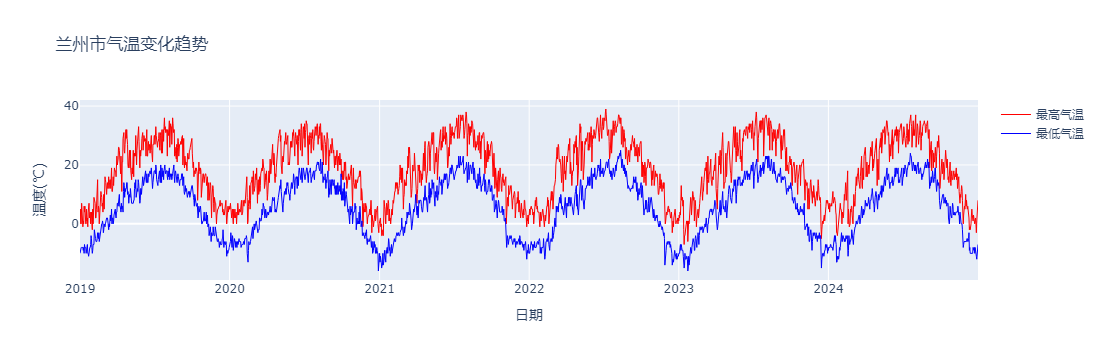

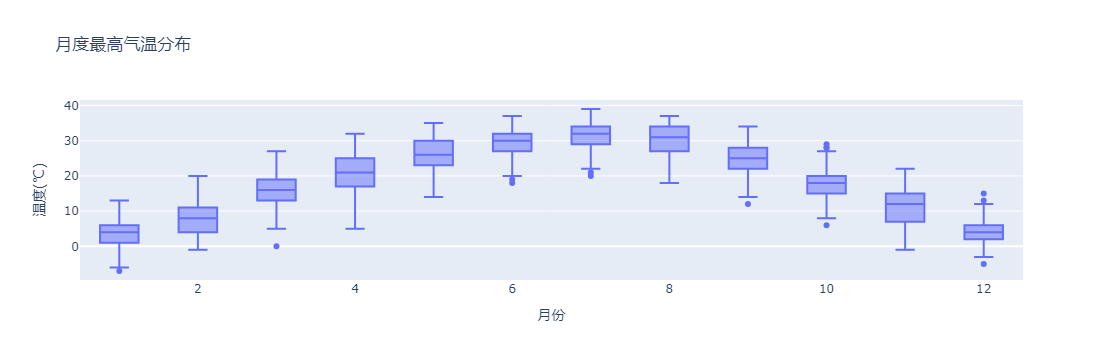

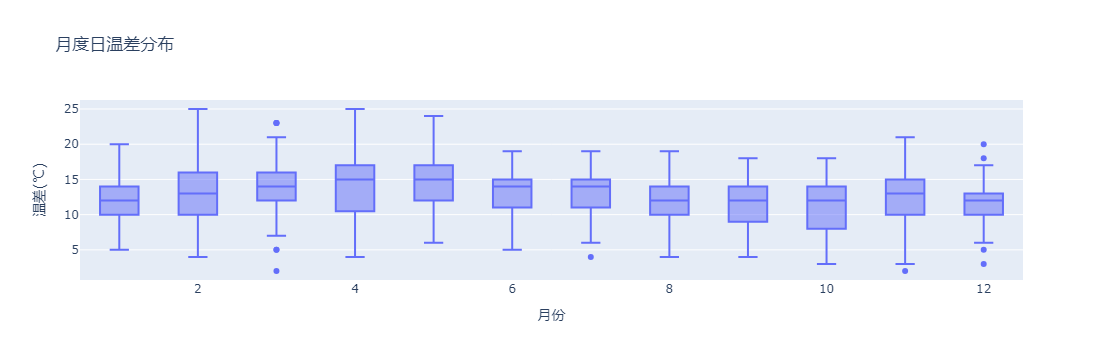

In [23]:
# 2.1 年度温度变化趋势
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['日期'],
    y=df['最高气温_数值'],
    name='最高气温',
    mode='lines',
    line=dict(color='red', width=1)
))

fig.add_trace(go.Scatter(
    x=df['日期'],
    y=df['最低气温_数值'],
    name='最低气温',
    mode='lines',
    line=dict(color='blue', width=1)
))

fig.update_layout(
    title='兰州市气温变化趋势',
    xaxis_title='日期',
    yaxis_title='温度(℃)',
    hovermode='x unified'
)

fig.show()

# 2.2 季节性温度分布
fig = px.box(df, x='月', y='最高气温_数值', title='月度最高气温分布')
fig.update_layout(
    xaxis_title='月份',
    yaxis_title='温度(℃)'
)
fig.show()

# 2.3 日温差分析
fig = px.box(df, x='月', y='日温差', title='月度日温差分布')
fig.update_layout(
    xaxis_title='月份',
    yaxis_title='温差(℃)'
)
fig.show()

## 3. 天气状况分析

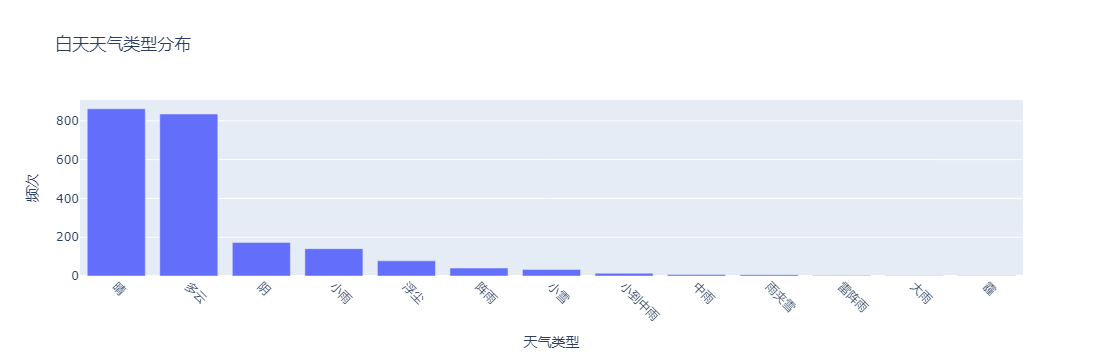

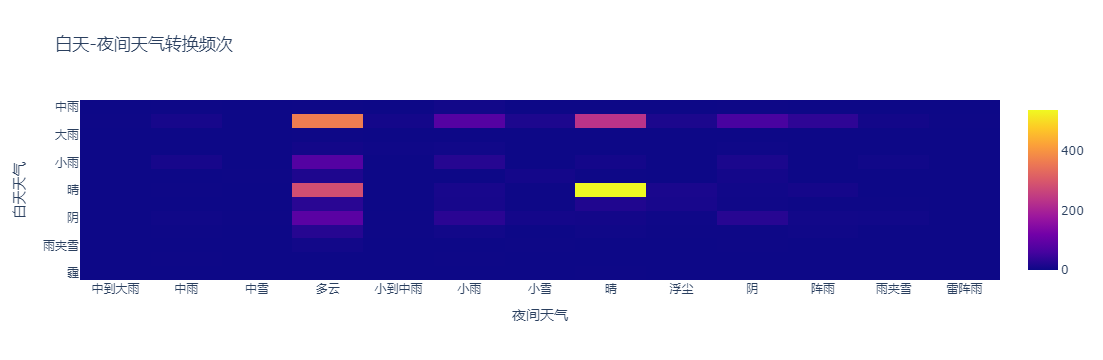

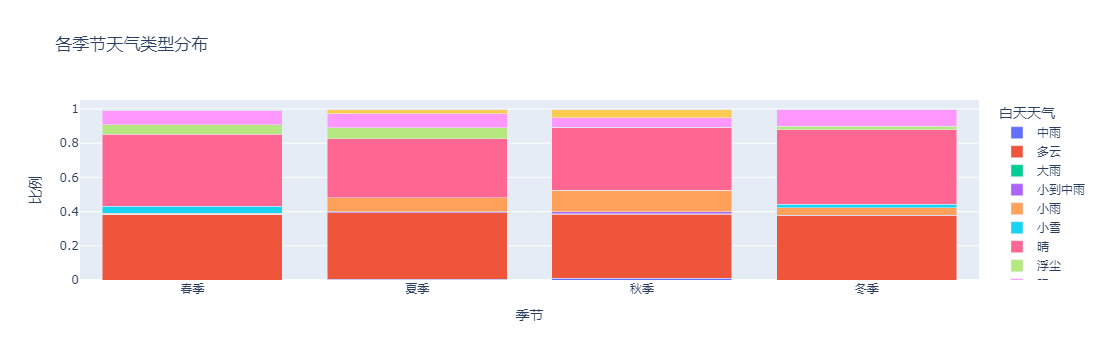

In [26]:
# 3.1 天气类型统计
weather_counts = df['白天天气'].value_counts()
fig = px.bar(x=weather_counts.index, y=weather_counts.values, title='白天天气类型分布')
fig.update_layout(
    xaxis_title='天气类型',
    yaxis_title='频次',
    xaxis_tickangle=45
)
fig.show()

# 3.2 白天/夜间天气对比
weather_compare = pd.crosstab(df['白天天气'], df['夜间天气'])
fig = px.imshow(weather_compare,
                title='白天-夜间天气转换频次',
                aspect='auto')
fig.show()

# 3.3 季节性天气分布
seasonal_weather = pd.crosstab(df['季节'], df['白天天气'], normalize='index')
fig = px.bar(seasonal_weather,
             title='各季节天气类型分布',
             barmode='stack')
fig.update_layout(
    xaxis_title='季节',
    yaxis_title='比例'
)
fig.show()

## 4. 风力分析

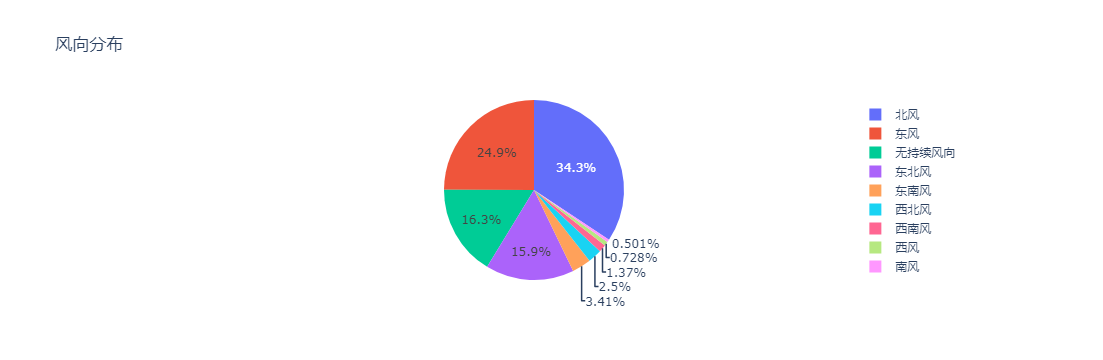

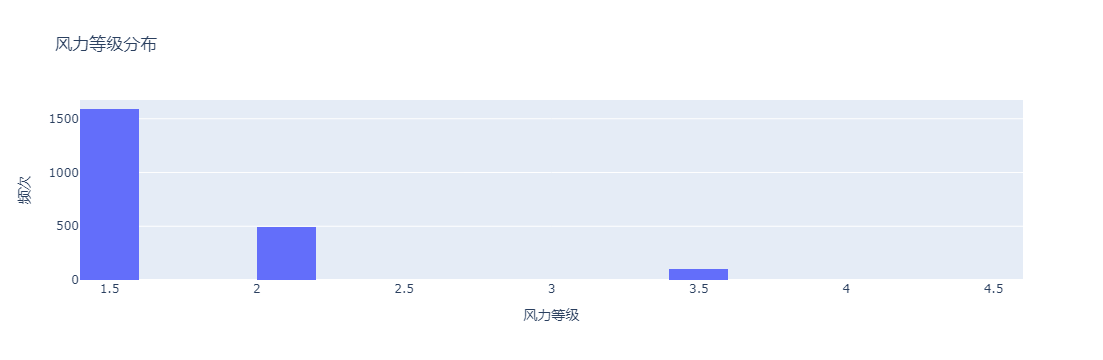

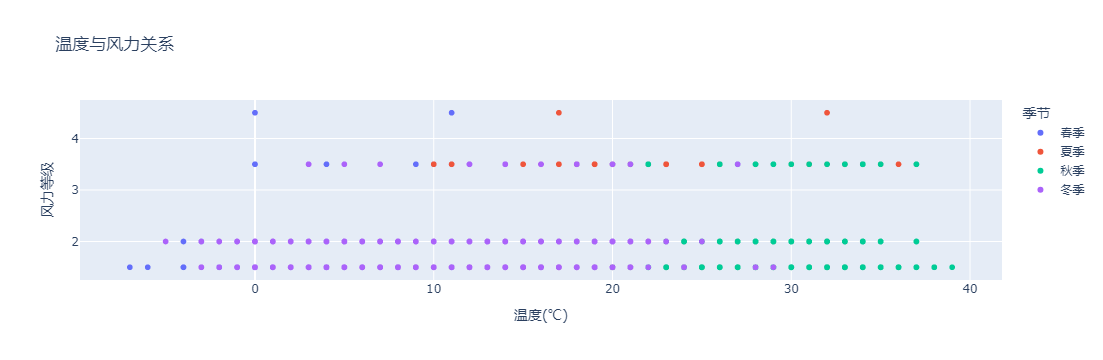

In [29]:
# 4.1 风向分布
wind_dir_counts = df['白天风向'].value_counts()
fig = px.pie(values=wind_dir_counts.values,
             names=wind_dir_counts.index,
             title='风向分布')
fig.show()

# 4.2 风力等级分布
fig = px.histogram(df, x='白天风力等级',
                  nbins=20,
                  title='风力等级分布')
fig.update_layout(
    xaxis_title='风力等级',
    yaxis_title='频次'
)
fig.show()

# 4.3 风力与温度关系
fig = px.scatter(df,
                x='最高气温_数值',
                y='白天风力等级',
                color='季节',
                title='温度与风力关系')
fig.update_layout(
    xaxis_title='温度(℃)',
    yaxis_title='风力等级'
)
fig.show()

## 5. 综合分析

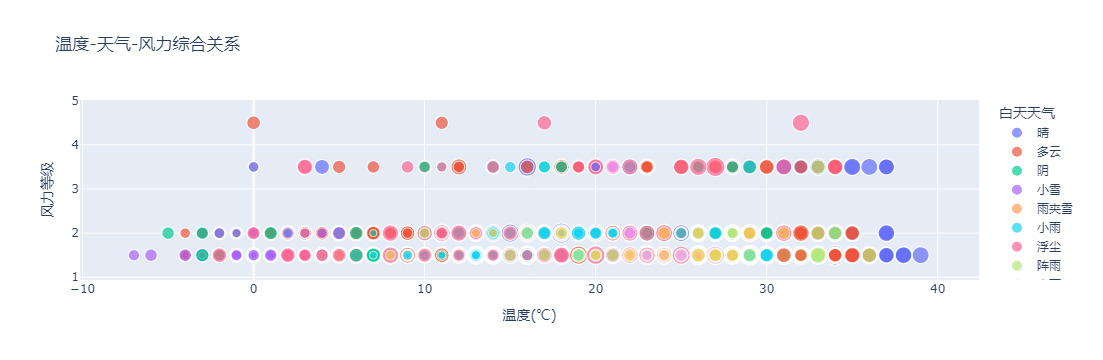

C:\Users\BACK\AppData\Local\Temp\ipykernel_21640\1958701993.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



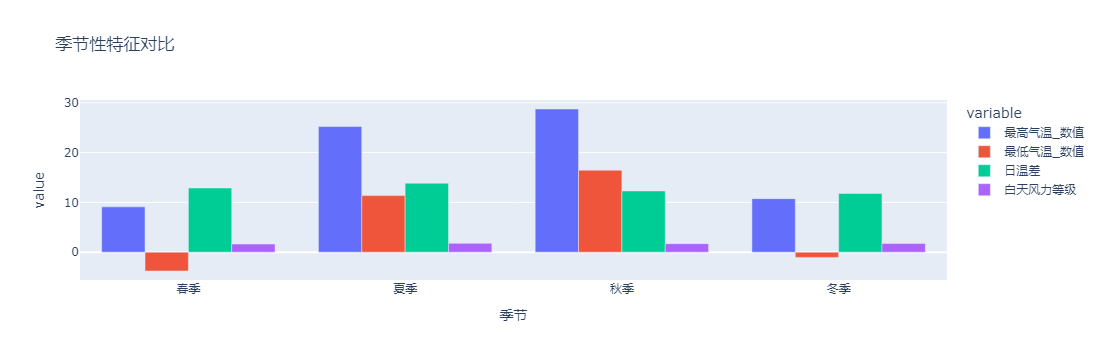

In [41]:
# 5.1 温度-天气-风力关系
fig = px.scatter(df,
                x='最高气温_数值',
                y='白天风力等级',
                color='白天天气',
                size='日温差',
                title='温度-天气-风力综合关系')
fig.update_layout(
    xaxis_title='温度(℃)',
    yaxis_title='风力等级'
)
fig.show()

# 5.2 季节性分析
seasonal_stats = df.groupby('季节').agg({
    '最高气温_数值': 'mean',
    '最低气温_数值': 'mean',
    '日温差': 'mean',
    '白天风力等级': 'mean'
}).round(2)

fig = px.bar(seasonal_stats,
             title='季节性特征对比',
             barmode='group')
fig.show()